# Lab : Textual data, pre-processing and features

**Author: matthieu.labeau@telecom-paris.fr**

## Objectives:

1. Confront yourself to the difficulties of retrieving and using (annotated) datasets.
2. Learn to clean and process textual data. Try several methods to represent this data.
3. Visualize these representations, and reflect on their potential usefulness for the dedicated task. 


## Necessary dependancies

We require the usual python package for storing and processing data:
- ```numpy```,  
- ```pandas```,
- ```altair``` (for visualisation)
- ```matplotlib``` (for pre-processing)

We will take a quick look at *crawling* for data:
- ```beautifulsoup```,

Besides, we will need the following packages for data pre-processing, representation and visualization:
- The Machine Learning API Scikit-learn ```sklearn``` : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit ```nltk```: http://www.nltk.org/install.html
- ```gensim```: https://radimrehurek.com/gensim/

And to get a taste of modern models:
- ```transformers```
- And you will need to install other small libraries to make the model run: ```sentencepiece```

**You can install all of these libraries via ```pip``` !**

In [11]:
# General imports
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
news = pd.read_csv("obsinfox.csv")

Let's look at the categories shown. A lot of labels are given, and there is several annotators for each articles.

In [3]:
print(news.dtypes)

URL                      object
Title                    object
Fake News                 int64
Places, Dates, People     int64
Facts                     int64
Opinions                  int64
Subjective                int64
Reported information      int64
Sources Cited             int64
False Information         int64
Insinuation               int64
Exaggeration              int64
Offbeat Title             int64
Annotator                object
dtype: object


Understand the structure of the table. Find a solution to get a list of all URLs and titles, without duplicates: 
<div class='alert alert-block alert-info'>
            Code:</div>

In [6]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   URL                    800 non-null    object
 1   Title                  800 non-null    object
 2   Fake News              800 non-null    int64 
 3   Places, Dates, People  800 non-null    int64 
 4   Facts                  800 non-null    int64 
 5   Opinions               800 non-null    int64 
 6   Subjective             800 non-null    int64 
 7   Reported information   800 non-null    int64 
 8   Sources Cited          800 non-null    int64 
 9   False Information      800 non-null    int64 
 10  Insinuation            800 non-null    int64 
 11  Exaggeration           800 non-null    int64 
 12  Offbeat Title          800 non-null    int64 
 13  Annotator              800 non-null    object
dtypes: int64(11), object(3)
memory usage: 87.6+ KB


In [16]:
urls = news["URL"].unique().tolist()
titles = news["Title"].unique().tolist()

You should see that you have $100$ examples - while we have the titles, it will clearly not be enough to find out which label applies. In order to get the text of the articles, we need to use the provided URLs.
This is actually something that is quite frequent, usually for certain datasets with copyright or licensing issues, in particular when third parties are forbidden to distribute the textual data themselves. 


As you can expect, this might cause issues in the long run !

In [13]:
import requests
from bs4 import BeautifulSoup

How to get the text ? Well, we can use a crawler which will take a look at the urls, get the html, and find the text associated to the article thanks to the html parser.
Happily, there exists a html tag specifically for this: ```article```. 
If you would like to know more, take a look at the [beautiful soup documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#get-text). We can propose code which roughly does what we want: 

In [18]:
# This function gives as the page as a BeautifulSoup object
# It represents the document as a nested data structure
def get_soup(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    return soup

# This function will look for the text under the tag "article"
# If there is not, it will get whatever text which is not labelled as 'style' or 'script' and remove empty lines
def get_article(url):
    item = get_soup(url)
    if (item.article == None):
        for script in item(['style', 'script']):
            script.extract()    
        text = item.get_text()
        lines = (line.strip() for line in text.splitlines())
        text = '\n'.join(line for line in lines if line)
        return text
    else:
        return item.article.text

Apply this to create a new column ```Text``` to our previously created table. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [20]:
news["Text"] = news["URL"].apply(get_article)

<div class='alert alert-block alert-warning'>
            Question:</div>
            
Look at the results. What are the different issues encountered ? How could we try to solve them ? 

In [22]:
print(news["Text"].iloc[0])



La relation entre la technologie et la religion

Publié le juillet 3, 2022  par  Le Saker Francophone 



Par Austin Cline − Le 27 fevrier 2019 − Source Learn Religions

De nombreux laïcs et non-croyants de toutes sortes ont tendance à considérer la religion et la science comme fondamentalement incompatibles. Cette incompatibilité est également imaginée pour s’étendre à la relation entre la religion et la technologie, puisque la technologie est un produit de la science et que la science ne peut pas aller de l’avant sans la technologie, surtout aujourd’hui. Ainsi, bon nombre d’athées s’émerveillent avec incrédulité du nombre d’ingénieurs qui sont également des créationnistes et du nombre de personnes dans les industries de haute technologie qui affichent de grandes motivations religieuses.

Mélanger technologie et religion
Pourquoi assistons-nous à un enchantement généralisé pour la technologie et en même temps à une résurgence mondiale du fondamentalisme religieux ? Nous ne devrions 

In [25]:
print(news["Text"].iloc[-1])


Accueil>Politique


            Bac 2019 : appel à poursuivre la grève jusqu'au brevet 
        




Auteur(s)
La rédaction de France-Soir



                        Publié le 18 juin 2019 - 09:38
                    




La grève des surveillants pourrait concerner l'ensemble des épreuves du bac 2019.
 





L'intersyndicale d'enseignants qui avait appelé à la grève de la surveillance pour l'épreuve de philosophie du bac a décidé d'étendre la protestation sur toute la durée de l'examen, au moins jusqu'au brevet des collèges. L'épreuve d'histoire géographie de ce mardi 18 devrait donc être également concernée, mais les répercussions sont pour l'instant limitées.La grève  de la surveillance des épreuves du bac 2019 devrait se poursuivre ce mardi pour celle d'histoire-géographie et même pour toutes les autres, peut-être même celles du brevet des collèges. Les syndicats ont en effet appelé à poursuivre le mouvement, qui dans un premier temps devait se concentrer uniquement sur l'épreuve 

This are issues you might encounter, but **do not solve them now ! You can directly move on to the next part.** Next, we will turn to easier-to-access data to work on cleaning and pre-processing text.

## II - Symbolic document representations

Let's give up on this, and find some data that is directly available... you should note that with a lot of user-generated content coming from websites like twitter and reddit, who have made their policies more severe over the year (data only to be accessed through their API; access then became paying) !

Still, we can use this [paper](https://aclanthology.org/2020.lrec-1.175/), which propose tweets annotated for the task of *sexism detection*. The data can be found in their [github](https://github.com/aollagnier/Sexism_Twitter_French/tree/main). Take a look at the description of the categories. 

We will:
1. Clean and pre-process this data as needed.
2. Obtain **symbolic** representations for each tweet, and look at their similarities. We will look at several ways of doing so.


What might we use these representations for ? 
- Better understanding the structure of this dataset, how it is organized; how documents compare between themselves. With textual data, this is of course valuable in itself for applied linguistics and social sciences; we can basically look at how words are being used. 
- Serve as feature representations for other models: this is a first transformation to then feed data into another model to perform a task. 

What kind of representations will we use ?
- Let us begin with something very simple. We will represent documents through **counts of word occurrences**. A very convenient way of doing so is to use a **Bag-of-Words (BoW)** vector, containing the counts of each word (regardless of their order of occurrence) in the document. 

In [14]:
tweets = pd.read_csv("gathered_tweets_labeled.csv", keep_default_na=False)

In [15]:
print(tweets.dtypes)

Unnamed: 0     int64
Username      object
Tweet         object
Category      object
dtype: object


In [16]:
tweets.head()

,Unnamed: 0,Username,Tweet,Category
0,0,maralpoutine,Cette Pécresse est une belle conasse https://t...,1
1,1,giralou,@Stop_Hidalgo De toute façon elle n’écoute per...,1
2,2,bettynutely,@marietheresero5 Faut VÉRIFIER les sources car...,0
3,3,Bonhygiene,@mariane_lab Et ne vous plaignez pas Madame Pé...,0
4,4,FredDu2007,@verity_france Déjà Zemour et Mélenchon n’ont ...,1


Instead of working with tables, we will put the data into *lists*; this will make it easier and more convenient to manipulate it at first. Try to understand exactly how we build the following lists, and why ? 

In [17]:
tweets_l = [t for t in tweets['Tweet'].tolist() if len(t) > 0]
categories_l = [c for c, t in zip(tweets['Category'].tolist(),tweets['Tweet'].tolist()) if len(t) > 0]

### II-1 Pre-processing: Tokenization and cleaning

The first thing to do is then to turn each tweet from a string into a list of words. The simplest method is to divide the string according to spaces with the command:
``text.split()``

But we must also be careful to remove special characters that may not have been cleaned up (such as HTML tags if the data was obtained from web pages). Since we're going to count words, we'll have to build a **list of tokens** appearing in our data. In our case, we'd like to reduce this list and make it uniform (ignore capitalization, punctuation, and the shortest words). 


We will therefore use a function adapted to our needs - but this is a job that we generally don't need to do ourselves, since there are many tools already adapted to most situations. 
For text cleansing, there are many scripts, based on different tools (regular expressions, for example) that allow you to prepare data. The division of the text into words and the management of punctuation is handled in a step called **tokenization**; if needed, a python package like NLTK contains many different *tokenizers*.

In [18]:
# We might want to clean the file with various strategies:
def clean_and_tokenize(text):
    """
    Cleaning a document with:
        - Lowercase        
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove words beginning by @ ? (Good choice ?)
    # text = re.sub(r'()@\w+', r'\1', text)
    tokens = text.split()        
    return tokens

<>:20: SyntaxWarning: invalid escape sequence '\['
<>:20: SyntaxWarning: invalid escape sequence '\['
C:\Users\MSI\AppData\Local\Temp\ipykernel_5228\3084775507.py:20: SyntaxWarning: invalid escape sequence '\['
  REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")


In [19]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


c:\Users\MSI\Desktop\Atef Master\Master2-SD-IPP\masterenv\Scripts\python.exe: No module named pip


In [20]:
# Or we might want to use an already-implemented tool. The NLTK package has a lot of very useful text processing tools, among them various tokenizers
# Careful, NLTK was the first well-documented NLP package, but it might be outdated for some uses. Check the documentation !
from nltk.tokenize import word_tokenize
import nltk
# Example
print(clean_and_tokenize(tweets_l[24]))
print(word_tokenize(tweets_l[24]))

['@gregtabibian', 'je', 'suis', 'un', 'fils', 'de', 'pute', 'à', 'trottinette', '😂', 'mais', 'pas', 'damalgame', 'on', 'ne', 'vote', 'pas', 'tous', 'hidalgo']
['@', 'gregtabibian', 'Je', 'suis', 'un', 'fils', 'de', 'pute', 'à', 'trottinette', '😂', 'Mais', 'pas', "d'amalgame", ',', 'on', 'ne', 'vote', 'pas', 'tous', 'Hidalgo', '...']


In [21]:
# The whole dataset
clean_tweets_l = [clean_and_tokenize(t) for t in tweets_l]

### III-2 Obtaning representations: bag-of-words

If we consider the set of all the words appearing in our $T$ training documents, which we note $V$ (the **vocabulary**), we can create an index, which is a bijection associating to each $w$ word an integer, which will be its position in $V$. 

Thus, for a document extracted from a set of documents containing $|V|$ different words, a BoW representation will be a vector of size $|V|$, whose value at the index of a word $w$ will be its number of occurrences in the document. 

The next function takes as input a list of documents (again, each in the form of a string) and returns:
- A vocabulary that associates, to each word encountered, an index
- A matrix, with rows representing documents and columns representing words indexed by the vocabulary. In position $(i,j)$, one should have the number of occurrences of the word $j$ in the document $i$.

The vocabulary, which was in the form of a *list* in the previous example, can be returned in the form of a *dictionary* whose keys are the words and values are the indices. Since the vocabulary lists the words in the corpus without worrying about their number of occurrences, it can be built up using a set (in python).

<div class='alert alert-block alert-info'>
            Code:</div>

In [22]:
def count_words(texts, voc = None):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    n_samples = len(texts)
    
    # If the vocabulary is not known, we need to build it
    if voc == None:
        words =set()
        for t in texts:
            words = words.union(set(clean_and_tokenize(t)))
        n_features = len(words)
        
        vocabulary = dict(zip(words, range(n_features)))
        
    # If it's given, it's quite easier
    else:
        vocabulary = voc
        n_features = len(voc)
    
    # Creating the matrix counts
    counts = np.zeros((n_samples, n_features))
    
    # Filling the matrix by iterating over the documents and counting the words
    for k, t in enumerate(texts): 
        for w in clean_and_tokenize(t):
            counts[k][vocabulary[w]] += 1.
    
    return vocabulary, counts

In [23]:
voc, bow = count_words(tweets_l)
print(bow.shape)

(1792, 9405)


We can also use ```scikit-learn```'s tools for this: the **CountVectorizer** class allows us to obtain the same kind of representations.

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

In [28]:
# Create and fit the vectorizer to the training data
vectorizer = CountVectorizer()
Bow = vectorizer.fit_transform(tweets_l)
bow_a = Bow.toarray()
print(bow_a.shape)

(1792, 8375)


Let's first look at the most frequent words. This will require some simple array manipulation:
- Retrieving the sum of all word occurences across documents,
- Sorting words according to their frequency,
- Plotting an histogram for the top words, using the count as value and the word as legend.

How can that influence our pre-processing ? 

<div class='alert alert-block alert-info'>
            Code:</div>

In [29]:
frequency = bow.sum(axis = 0)
top_words = np.argsort(frequency)[::-1] 

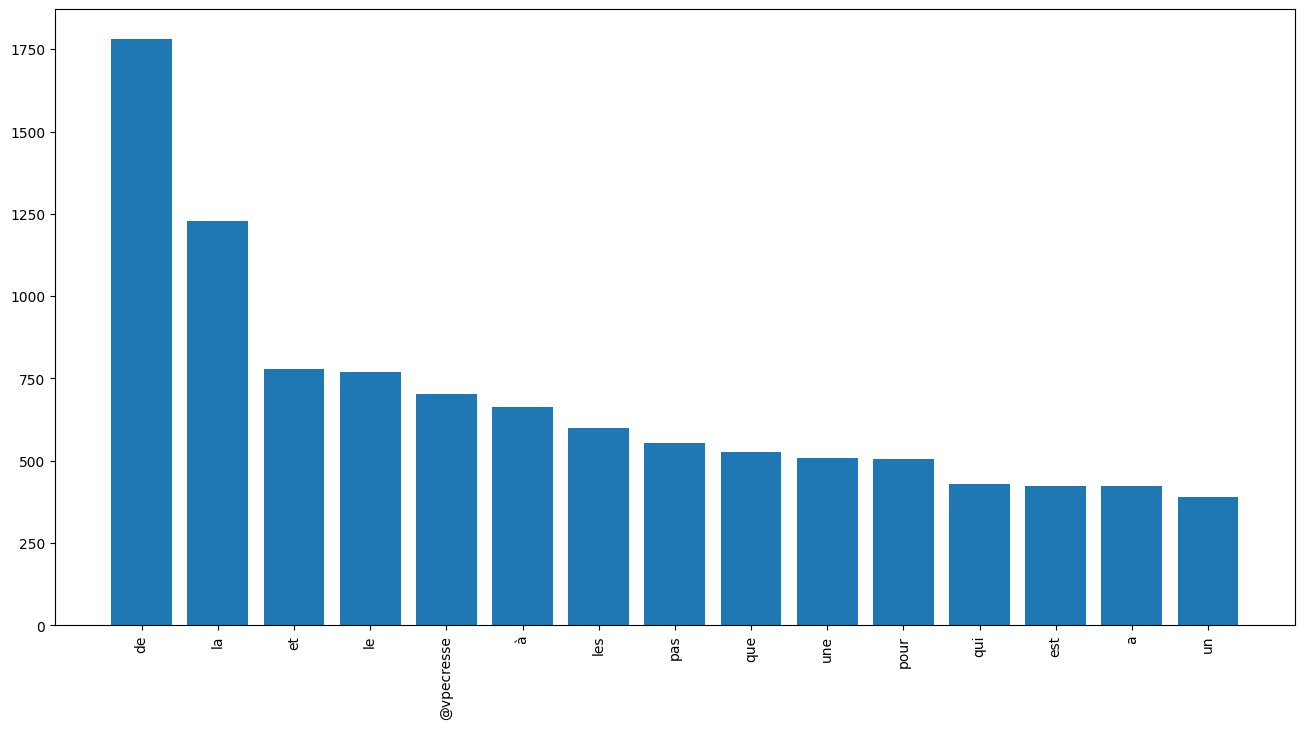

In [30]:
rev_voc = {i: w for w, i in voc.items()}
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(15), frequency[top_words[:15]])
ax.set_xticks(range(15))
ax.set_xticklabels([rev_voc[i] for i in top_words[:15]], rotation='vertical')
plt.show()

### II-3 Vector comparison

We can use these very large-dimensional vectors for a very simple semantic analysis: for example, by looking for the nearest neighbors of a tweet. 
However, we need to be careful to the distance that we use: should it be *Euclidean* or *Cosine*.

In [31]:
def euclidean(u, v):
    return np.linalg.norm(u-v)

def length_norm(u):
    return u / np.sqrt(u.dot(u))

def cosine(u, v):
    return 1.0 - length_norm(u).dot(length_norm(v))

from sklearn.neighbors import NearestNeighbors

Implement a function using the ```NearestNeighbors``` class for ```sklearn```, allowing you to print the closest document of a reference index. Try both distances and both representations.

<div class='alert alert-block alert-info'>
            Code:</div>

In [32]:
def print_neighbors(distance, texts, representations, index, k=5):
    """
    Parameters
    ----------
    distance : function
        The distance to use to compare documents
    texts : list of str
        The texts
    representations: 2D Array
        Vector representations of the texts, in the same order
    index: int
        Index of the document for which to return nearest neighbors
    k: int
        Number of neighbors to display    
    """
    
    # Get the reference document
    reference_text = texts[index]
    reference_vector = representations[index]
    
    # Create NearestNeighbors object with the specified distance metric
    if distance == euclidean:
        metric = 'euclidean'
    elif distance == cosine:
        metric = 'cosine'
    else:
        metric = 'euclidean'  # default
    
    nn = NearestNeighbors(n_neighbors=k+1, metric=metric)
    nn.fit(representations)
    
    # Find neighbors (k+1 because the first neighbor will be the document itself)
    distances, indices = nn.kneighbors([reference_vector])
    
    # Remove the first neighbor (which is the document itself)
    neighbor_indices = indices[0][1:k+1]
    neighbor_distances = distances[0][1:k+1]
    
    print("Plus proches voisins de: \n '%s' \n selon la distance '%s':" % (reference_text, distance.__name__))
    for i, (neighbor_idx, dist) in enumerate(zip(neighbor_indices, neighbor_distances)):
        print(f"{i+1}. (distance: {dist:.4f}) {texts[neighbor_idx]}")
    print("\n")

In [33]:
print_neighbors(euclidean, tweets_l, bow, 24)
print_neighbors(cosine, tweets_l, bow, 24)

print_neighbors(euclidean, tweets_l, bow_a, 24)
print_neighbors(cosine, tweets_l, bow_a, 24)

Plus proches voisins de: 
 '@gregtabibian Je suis un fils de pute à trottinette 😂 
Mais pas d'amalgame, on ne vote pas tous Hidalgo...' 
 selon la distance 'euclidean':
1. (distance: 4.5826) hidalgo à salopé PARIS !
2. (distance: 4.6904) @vpecresse Sale pute
3. (distance: 4.6904) grosse pute https://t.co/jFH6KKZzx2
4. (distance: 4.7958) @VincentJEANBRUN @Anne_Hidalgo alors vieille pute? On prend pas le vélo?
5. (distance: 4.7958) @vpecresse Salope de pecresse


Plus proches voisins de: 
 '@gregtabibian Je suis un fils de pute à trottinette 😂 
Mais pas d'amalgame, on ne vote pas tous Hidalgo...' 
 selon la distance 'cosine':
1. (distance: 0.4888) Je suis même pas française je ne vote pas mais je viens de regarder tout le programme de votre pute de pecresse, elle est d’un ridicule . Pathétique
2. (distance: 0.5970) @LCI @fhollande @Anne_Hidalgo @faureolivier @EliMartichoux Ce n'est pas un tort que de ne pas plébisciter une candidate en laquelle vs ne croyez pas ! Même pour un membre de s

### II-4 Improving representations with TF-IDF

This is the product of the frequency of the term (TF) and its inverse frequency in documents (IDF).
This method is usually used to measure the importance of a term $i$ in a document $j$ relative to the rest of the corpus, from a matrix of occurrences $ words \times documents$. Thus, for a matrix $\mathbf{T}$ of $|V|$ terms and $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T, w) = \log\left(\frac{D}{|\{d : T_{w,d} > 0\}|}\right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(X, w, d) \cdot \text{IDF}(T, w)$$

TF-IDF is generally better suited to low-density matrices, since it will penalize terms that appear in a large part of the documents. 

Implement a function transforming the BOW representations we obtained as output of ```count_words``` into TF-IDF representations. Do not forget about **smoothing** ! 
<div class='alert alert-block alert-info'>
            Code:</div>

In [35]:
from sklearn.preprocessing import normalize
import numpy as np

def tfidf_transform(bow):
    """
    Inverse document frequencies applied to our bag-of-words representations
    """
    # IDF
    d = bow.shape[0]  # number of documents
    in_doc = np.sum(bow > 0, axis=0)  # number of documents containing each word
    idf = np.log(d / (in_doc + 1))  # smoothing with +1 to avoid division by zero
    
    # TF
    sum_vec = np.sum(bow, axis=1, keepdims=True)  # sum of words per document
    tf = bow / (sum_vec + 1)  # smoothing with +1 to avoid division by zero
    
    # TF-IDF
    tf_idf = tf * idf
    
    return tf_idf

In [36]:
tfidf = tfidf_transform(bow)
print(tfidf.shape)

(1792, 9405)


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
# Create and fit the vectorizer to the training data
tfidf_vectorizer = TfidfVectorizer()
Tfidf = tfidf_vectorizer.fit_transform(tweets_l)
tfidf_a = Tfidf.toarray()
print(tfidf_a.shape)

(1792, 8375)


In [39]:
print_neighbors(euclidean, tweets_l, tfidf_a, 24)
print_neighbors(cosine, tweets_l, tfidf_a, 24)

print_neighbors(euclidean, tweets_l, tfidf, 24)
print_neighbors(cosine, tweets_l, tfidf, 24)

Plus proches voisins de: 
 '@gregtabibian Je suis un fils de pute à trottinette 😂 
Mais pas d'amalgame, on ne vote pas tous Hidalgo...' 
 selon la distance 'euclidean':
1. (distance: 1.1561) Je suis même pas française je ne vote pas mais je viens de regarder tout le programme de votre pute de pecresse, elle est d’un ridicule . Pathétique
2. (distance: 1.2449) je maudis Delanoe, Hidalgo, la RATP, les verts, et tous les autres fils de pute
3. (distance: 1.2482) @StroJPP @MederickLahire @CharlesAslangul @davidlisnard @ZemmourEric Ce que vous dites n'est pas forcément vrai, je regarde Zemmour que je suis, je regarde MLP que je suis pas, je regarde Pécresse que je suis pas, je regarde Mélenchon que je suis, il n'y a pas de règles précises https://t.co/4M04EOgkCG
4. (distance: 1.2569) @WKoubarak Moi

Mais vue que je suis pas candidat alors jcp, tout ce que je sais c'est que quoi qu'il arrive je vote pas pour :
Mélenchon
Macron la pute
Le duo des meuf conne Hidalgo et l'autre j'ai oublié sont

<div class='alert alert-block alert-warning'>
            Question:</div>
            
Try to interpret the nearest neighbors for each distance - think about how they are computed. Which kind of documents are privileged, for each of them ? How might the representation affect this ? 

## III - Data visualization

**Question:** can these representations capture what the dataset is about ? We will use visualization to find out in this last section. More precisely, we would like to check if lexical features (which we tried to rid of the influence of word frequency with TF-IDF), are enough to capture the characteristics of the dataset (which are reflected in the **annotations**.

We will not use supervised Machine Learning yet, but rather try to visualize our data in 2D: it's all about reducing the dimension with techniques that keep what's (statistically) more important.

In [40]:
import altair as alt
import pandas as pd

### III - 1 With PCA

We will now use **principal components analysis** (PCA) to visualize our data in two dimensions. This is equivalent to applying SVD to the covariance matrix of the data, in order for the principal components to be independant from each other an maximize the variance of the data. We use the class ```PCA``` from ```scikit-learn```.

<div class='alert alert-block alert-warning'>
            Question:</div>
                        
Working on TF-IDF representations and displaying classes: 
- What can we observe ?
- How can we interpret this with respect to our features ? 


In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
docs_pca = pca.fit_transform(tfidf)

In [42]:
data = pd.DataFrame({'x': docs_pca[:,0],
                     'y': docs_pca[:,1],
                     'tweet': tweets_l,
                     'Category': categories_l})

In [43]:
alt.Chart(data[:]).mark_circle(size=200).encode(
    x="x", y="y", color='Category',
    tooltip=['tweet']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

### III - 2 With T-SNE

From the ```sklearn``` documentation: 
- t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. **with different initializations we can get different results**.
- In particular, t-SNE has the advantage to reveal data that lie in multiple, different, manifolds or clusters.
- It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.

From this recommendation, we will initialize ```TSNE``` with PCA (choosing the argument ```init='pca'``` when creating the class).

In [44]:
from sklearn.manifold import TSNE

In [45]:
docs_tsne = TSNE(n_components=2, learning_rate='auto',
                  init='pca').fit_transform(tfidf)
print(docs_tsne.shape)

(1792, 2)


In [46]:
data = pd.DataFrame({'x': docs_tsne[:,0],
                     'y': docs_tsne[:,1],
                     'tweet': tweets_l,
                     'Category': categories_l})

In [47]:
alt.Chart(data[:]).mark_circle(size=200).encode(
    x="x", y="y", color='Category',
    tooltip=['tweet']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

<div class='alert alert-block alert-warning'>
            Question:</div>
                        
- Is there any conclusion we can draw with respect to the lexical features and how they allow us to group the documents in this dataset ? 

### III - 3 Topic modeling

Now, the goal is to re-use the bag-of-words representations we obtained earlier - but reduce their dimension before visualization. 

The underlying idea is to **take advantage of the latent structure in the association between the set of
words and the set of documents**. Many methods have been designed to do this - the earliest being **topic models**. 

Note that this allows to obtain reduced document representations, in a **topic space, common to documents and words** - where each document is described as a vector of topics and for each topic, we have access to the importance of words. 


We will do this with two models:
- Using the ```TruncatedSVD```, we will **linearly** reduce the dimension of our BOW representations. This is called *Latent Semantic Analysis* (LSA). 
- Using a *generative model* based on several assumptions on how a document is generated through topics, which the model will retrieve: this is ```LatentDirichletAllocation``` (LDA).

We use here another dataset from this [paper](https://aclanthology.org/2024.latechclfl-1.28/) which includes quite more categories and will be more interesting to explore, as we can expect it to contain clusters clearly visible through looking at lexical features. You can find the dataset on their [git repository](https://git.unistra.fr/thealtres/stage-direction-classif-french-transfer-learning).

In [48]:
AS13_df = pd.read_table("stgdir_labelGeneric.csv",
                        sep='|', 
                        dtype={'description' : 'object', 'labelGeneric': 'category', })
labelCol = 'labelGeneric'
class_names = sorted(AS13_df[labelCol].unique().categories.to_list())
label2id = {class_names[i]:i for i in range(len(class_names))}
id2label = {i:class_names[i] for i in range(len(class_names))}

In [49]:
AS13_df = AS13_df.drop_duplicates()

First, apply the same pipeline than before:
- Does the data need to be cleaned and pre-processed ?
- Obtain BOW and TF-IDF representations.
- Visualize them with T-SNE.

<div class='alert alert-block alert-info'>
            Code:</div>

In [51]:
# Obtain BOW representations
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_th = CountVectorizer(max_features=5000, stop_words='english')
bow_th = vectorizer_th.fit_transform(AS13_df['description'])
voc_th = vectorizer_th.vocabulary_

In [53]:
# Transform them into TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_th = tfidf_transformer.fit_transform(bow_th)

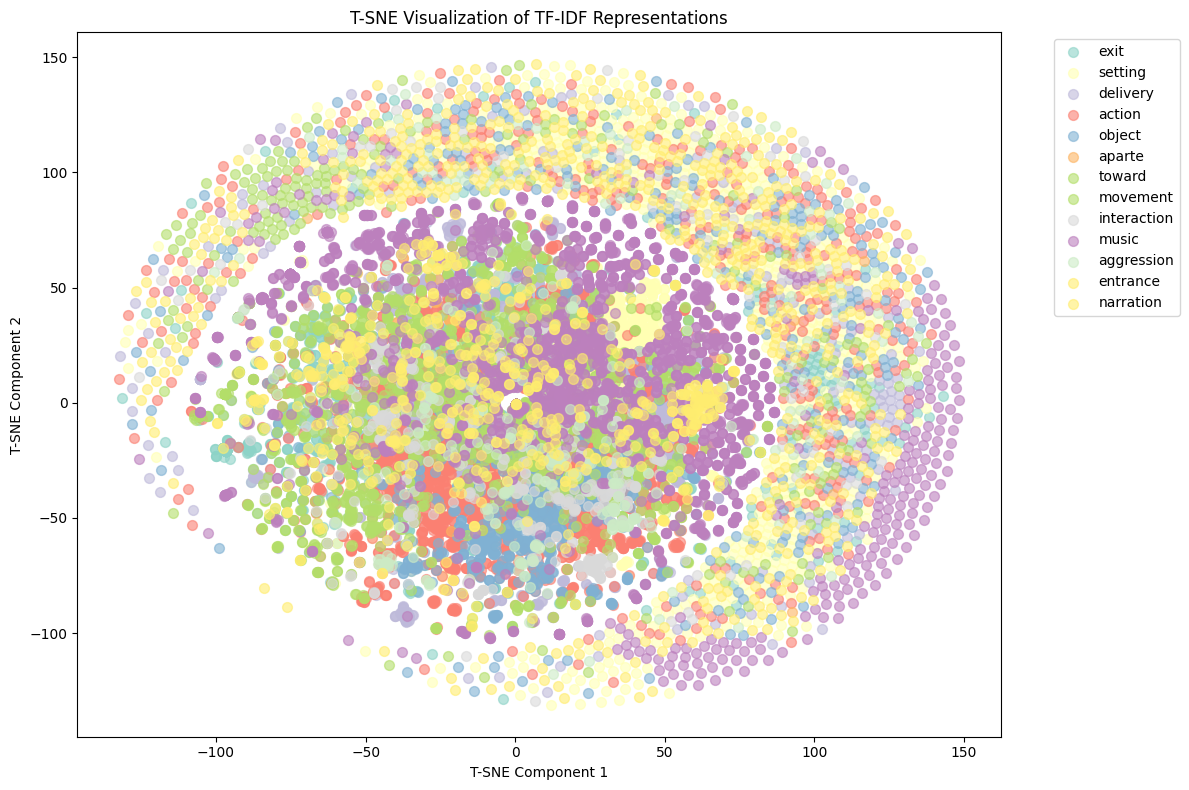

In [55]:
# Visualize the result of dimension reduction via T-SNE; display the classes

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tfidf_tsne = tsne.fit_transform(tfidf_th.toarray())

# Create a plot
plt.figure(figsize=(12, 8))

# Get unique labels and create a color map
unique_labels = AS13_df[labelCol].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))

# Plot each class with a different color
for i, label in enumerate(unique_labels):
    mask = AS13_df[labelCol] == label
    plt.scatter(tfidf_tsne[mask, 0], tfidf_tsne[mask, 1], 
               c=[colors[i]], label=label, alpha=0.6, s=50)

plt.title('T-SNE Visualization of TF-IDF Representations')
plt.xlabel('T-SNE Component 1')
plt.ylabel('T-SNE Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [56]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

**Latent Semantic Analysis**: let us choose an arbitrary number of topics - which will be the size of the joint *topic space*.

In [57]:
n_topics = 50
lsa = TruncatedSVD(n_components = n_topics)
lsa_topics = lsa.fit_transform(tfidf_th)

In [58]:
# Correspondances between documents and topics
print(lsa_topics.shape)
# Correspondances between topics and words
print(lsa.components_.shape)

(14613, 50)
(50, 5000)


In [59]:
# Reversing the vocabulary to retrieve words from indexes, allowing to find the most important words for each topic
rev_voc_th = {i: w for w, i in voc_th.items()}

In [60]:
def most_important_words(n, reverse_vocabulary, topic_model):
    out = []
    for i, topic in enumerate(topic_model.components_):
        out.append([reverse_vocabulary[j] for j in topic.argsort()[:-n-1:-1]])
    return out

In [61]:
words = most_important_words(8, rev_voc_th, lsa)
for i, topic in enumerate(words[:15]):
    print("Topic ", i+1, " : ", topic)

Topic  1  :  ['il', 'la', 'le', 'air', 'et', 'elle', 'en', 'les']
Topic  2  :  ['air', 'vous', 'je', 'la', 'des', 'vaudeville', 'noté', 'du']
Topic  3  :  ['sort', 'avec', 'elle', 'air', 'par', 'gauche', 'le', 'droite']
Topic  4  :  ['il', 'air', 'lui', 'sort', 'montre', 'sa', 'son', 'donne']
Topic  5  :  ['la', 'elle', 'main', 'lettre', 'porte', 'table', 'scène', 'lui']
Topic  6  :  ['elle', 'en', 'se', 'va', 'air', 'lui', 'son', 'sa']
Topic  7  :  ['en', 'montrant', 'va', 'et', 'les', 'se', 'ils', 'sort']
Topic  8  :  ['se', 'les', 'et', 'ils', 'au', 'des', 'tous', 'sortent']
Topic  9  :  ['montrant', 'lui', 'les', 'donne', 'son', 'et', 'des', 'sa']
Topic  10  :  ['se', 'montrant', 'le', 'ils', 'retire', 'lui', 'la', 'genoux']
Topic  11  :  ['au', 'montrant', 'se', 'son', 'du', 'une', 'fond', 'retire']
Topic  12  :  ['entre', 'montrant', 'son', 'dans', 'sa', 'avec', 'et', 'il']
Topic  13  :  ['entre', 'les', 'au', 'lui', 'se', 'donne', 'le', 'ils']
Topic  14  :  ['les', 'montrant', '

With a dataset this size, over **short texts**, it is difficult to interpret the topics (many short words, even with TF-IDF). Let's apply T-SNE ! 

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Visualize the result of dimension reduction via T-SNE; display the classes
...

**Latent Dirichlet Allocation**: 

In [ ]:
lda = LatentDirichletAllocation(n_components = n_topics)
lda_topics_th = lda.fit_transform(bow_th)

In [ ]:
words = most_important_words(8, rev_voc_th, lda)
for i, topic in enumerate(words[:15]):
    print("Topic ", i+1, " : ", topic)

In [ ]:
print(lda_topics_th.shape)

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Visualize the result of dimension reduction via T-SNE; display the classes
...

<div class='alert alert-block alert-info'>
            Code:</div>
            
- Apply the pipeline to obtain a t-sne visualisation over the same representations, but for the **second dataset** (*gathered_tweets_labeled*). Did it work as expected ? 

### III - 4 Take away

**Idea**: the key to improving representations is to embed data capturing text statistics in a compact space.

But how ? 
Let's look at how a compact **modern (deep learning based) model** can better capture what's happening in our dataset:

In [ ]:
%%capture output

from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("cmarkea/distilcamembert-base")
model = AutoModel.from_pretrained("cmarkea/distilcamembert-base")
model.eval()

In [ ]:
# This code is very inefficient: it will take documents one by one and make them go through the model
# We can usually process several of them together to gain time: this is called batching
# Batching may require a large quantity of memory, and to avoid any issue when running this locally,
# we will keep this (very slow and) inefficient solution. 
vectors = []
for i, example in enumerate(AS13_df['description'].tolist()):
    inputs = tokenizer(example, truncation=True, padding=True, return_tensors="pt")
    outputs = model(**inputs)
    vectors.append(outputs.last_hidden_state[0,0,:].detach().numpy()[np.newaxis, :])

In [ ]:
# The model outputs vectors of size 768
cam_rep = np.concatenate(vectors, axis=0)
print(cam_rep.shape)

In [ ]:
docs_tsne_th = TSNE(n_components=2, learning_rate='auto',
                    init='random', metric='cosine',
                    perplexity=50.0, square_distances=True).fit_transform(cam_rep)
print(docs_tsne_th.shape)

data_th = pd.DataFrame({'x': docs_tsne_th[:,0],
                        'y': docs_tsne_th[:,1],
                        'Text': AS13_df['description'],
                        'Category': AS13_df['labelGeneric']})

alt.data_transformers.disable_max_rows()
alt.Chart(data_th[:]).mark_circle(size=200).encode(
    x="x", y="y", color='Category',
    tooltip=['Text']
    ).interactive().properties(
    width=500,
    height=500
)

We will see how such a model (*CamemBERT*) works in a few months ! 